# Exploratory Analysis – Password Strength Detector

We aim to detect weak passwords using a machine learning model trained on labeled real-world data.

Typical password strength checkers rely on length and character diversity. Our goal is to catch weak patterns (like "Hol@123!") that technically pass those checks but are still insecure.

## 📥 Data Overview
Let's load and examine the structure of the password dataset.

In [4]:
import pandas as pd

# Load sample (e.g. 100k per class for speed)
N = 100_000

with open("../data/rock_you_filtered.txt", encoding="utf-8") as f:
    weak = [line.strip() for i, line in enumerate(f) if i < N]

with open("../data/strong_passwords.txt", encoding="utf-8") as f:
    strong = [line.strip() for i, line in enumerate(f) if i < N]

df = pd.DataFrame(weak + strong, columns=["password"])
df["label"] = [0] * len(weak) + [1] * len(strong)


In [3]:
# Preview the first few rows
df.head()

,password,label
0,harrylaw,0
1,patsythecat,0
2,00foxy00,0
3,canedo29,0
4,pars011005,0


In [5]:
# Basic info about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  200000 non-null  object
 1   label     200000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [6]:
# Summary statistics
df.describe(include='all')

,password,label
count,200000,200000.000000
unique,200000,NaN
top,harrylaw,NaN
freq,1,NaN
mean,NaN,0.500000
std,NaN,0.500001
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.500000
75%,NaN,1.000000


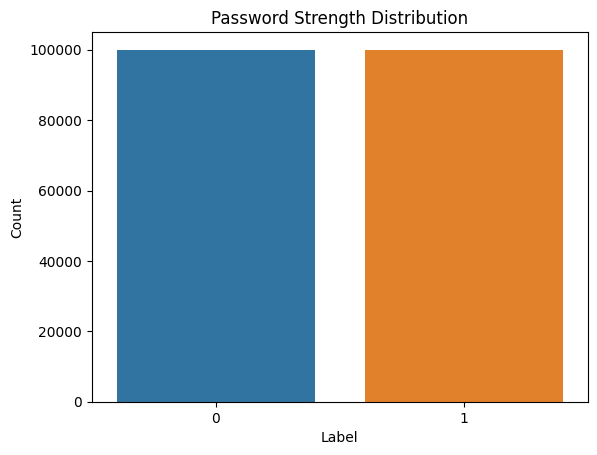

In [7]:
# Class distribution (label counts)
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data=df, x='label')
plt.title('Password Strength Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Text(0.5, 0.98, '')

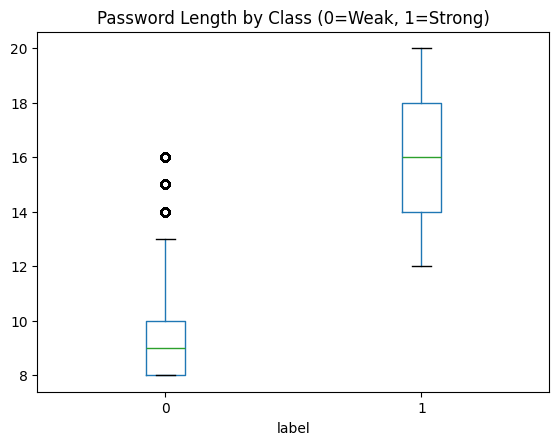

In [8]:
import matplotlib.pyplot as plt

df["length"] = df["password"].str.len()
df.boxplot(column="length", by="label", grid=False)
plt.title("Password Length by Class (0=Weak, 1=Strong)")
plt.suptitle("")


In [9]:
import math

def calc_entropy(pwd):
    charset = 0
    if any(c.islower() for c in pwd): charset += 26
    if any(c.isupper() for c in pwd): charset += 26
    if any(c.isdigit() for c in pwd): charset += 10
    if any(c in "!@#$%^&*()-_+=[]{};:'\",.<>/?\\|" for c in pwd): charset += 32
    if charset == 0: return 0
    return round(len(pwd) * math.log2(charset), 2)

df["entropy"] = df["password"].apply(calc_entropy)

df.groupby("label")["entropy"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,100000.0,47.393712,12.046555,26.58,41.36,46.53,51.70,104.87
1,100000.0,104.223542,17.264494,62.04,91.76,104.87,117.98,131.09


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), max_features=5000) # "char" -> character n-grams, "ngram_range=(2, 5)" -> consider 2-grams to 5-grams, 5000 features max -> limit vocabulary size
X = vectorizer.fit_transform(df["password"])
X.shape

# Show sample TF-IDF vector
import pandas as pd
# Show top 10 features for the first password
pd.DataFrame(X[0].toarray(), columns=vectorizer.get_feature_names_out()).T.sort_values(by=0, ascending=False).head(10)


,0
yla,0.389728
rry,0.381513
arr,0.355858
har,0.341814
aw,0.289822
yl,0.277967
rr,0.275475
ry,0.273932
ha,0.231535
la,0.224702


In [15]:
from sklearn.preprocessing import StandardScaler
import scipy.sparse
from src.utils import calc_entropy

# Calcular longitud y entropía de las contraseñas
df["length"] = df["password"].apply(len)
df["entropy"] = df["password"].apply(calc_entropy)

# Concatenate TF-IDF features with length and entropy
extra = df[["length", "entropy"]].values
scaler = StandardScaler()
extra_scaled = scaler.fit_transform(extra) # Standardize length and entropy features

X_final = scipy.sparse.hstack([X, extra_scaled]) # Combine TF-IDF with length and entropy features
y = df["label"]


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train model using SGDClassifier with log loss
model = SGDClassifier(loss="log_loss", random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19993
           1       0.99      0.99      0.99     20007

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



In [13]:
df_test = df.iloc[y_test.index]
df_test = df_test.copy()
df_test["pred"] = y_pred
errors = df_test[df_test["label"] != df_test["pred"]]
errors.sample(15)


,password,label,length,entropy,pred
40055,Lukas-Kato05,0,12,78.66,1
1749,mcds414-eta540,0,14,85.22,1
49484,greenspider.10,0,14,85.22,1
72888,315black-angelme,0,16,97.40,1
99984,likkle-star-lu,0,14,82.01,1
32980,sofiajan3007**,0,14,85.22,1
195040,bPWUARMakwFY,1,12,68.41,0
20888,-v[86Imujiyddyo,0,15,98.32,1
41259,iyd86'[u0b'qot,0,14,85.22,1
186787,J2DVAsp4HU7k,1,12,71.45,0



### Conclusions

✅ Including entropy and length improved model performance slightly.

❌ TF-IDF alone struggles with passwords like "qwerty123" or "abcabc" — common patterns that aren't always caught by naive rule-based systems.